In [1]:
import torch
import torch.nn as nn

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Get Data

Our dataset is a subset of the Food 101 dataset.


Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).
Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).


Why do this?


When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.


The whole point is to speed up how fast you can experiment.

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/"pizza-steak-sushi"

#"Creating directory : "
if image_path.is_dir():
  print(f" {image_path} The path aldready exists")
else:
  print(f"{image_path} doesn't exist , creating one")
  image_path.mkdir(parents = True , exist_ok = True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading , pizza , steak , sushi data..")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip" , "r") as zip_ref:
  print("Unzipping : ")
  zip_ref.extractall(image_path)

data/pizza-steak-sushi doesn't exist , creating one
Unzipping : 


#Data preparation and data Exploration

In [6]:
import os

def walk_through_dir(dir_path):
  for dirpath,dirname,filename in os.walk(dir_path):
    print(f"{len(dirname)} directories and {len(filename)} images in {dirpath}")

In [7]:
walk_through_dir(image_path)

2 directories and 0 images in data/pizza-steak-sushi
3 directories and 0 images in data/pizza-steak-sushi/test
0 directories and 25 images in data/pizza-steak-sushi/test/pizza
0 directories and 31 images in data/pizza-steak-sushi/test/sushi
0 directories and 19 images in data/pizza-steak-sushi/test/steak
3 directories and 0 images in data/pizza-steak-sushi/train
0 directories and 78 images in data/pizza-steak-sushi/train/pizza
0 directories and 72 images in data/pizza-steak-sushi/train/sushi
0 directories and 75 images in data/pizza-steak-sushi/train/steak


In [8]:
#Set up train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir , test_dir

(PosixPath('data/pizza-steak-sushi/train'),
 PosixPath('data/pizza-steak-sushi/test'))

#Visualizing image

1. Get all of the image paths


2. Pick a random image path using Python's random.choice()


3. Get the image class name using pathlib. Path.parent.stem


4. Since we're working with images, let's open the image with Python's PIL


5. We'll then show the image and print metadata

Random image path : data/pizza-steak-sushi/test/steak/354513.jpg
Image class : steak
Image height : 382
Image width : 512


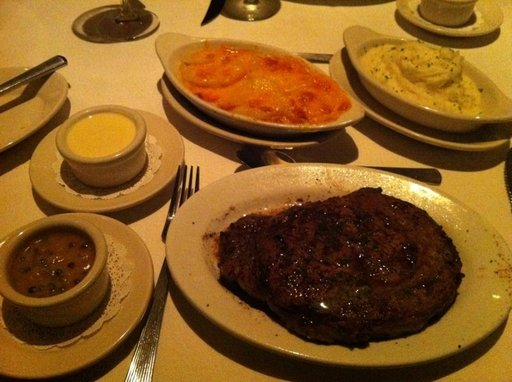

In [9]:
import random
from PIL import Image

#Setting up reproducability
random.seed(42)

#Get all image path
image_path_list = list(image_path.glob("*/*/*"))

#Picking a random image path
random_image_path = random.choice(image_path_list)

#Get the class name of the image
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path : {random_image_path}")
print(f'Image class : {image_class}')
print(f'Image height : {img.height}')
print(f"Image width : {img.width}")
img

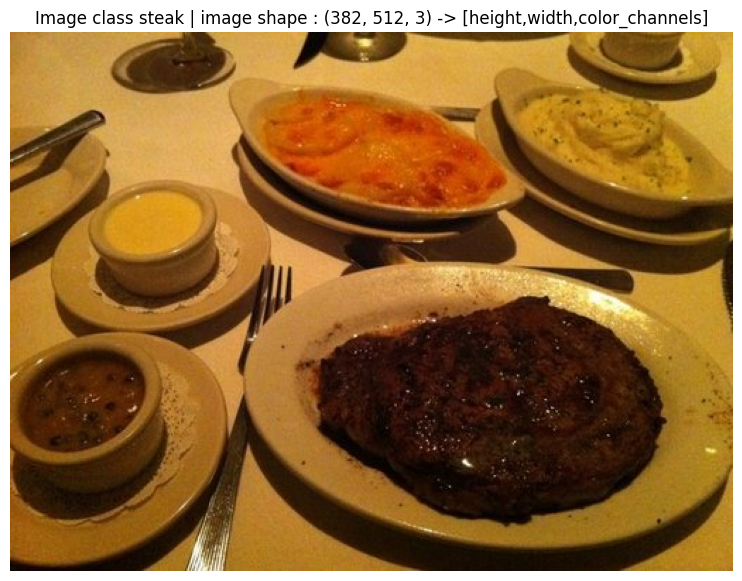

In [10]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class {image_class} | image shape : {img_as_array.shape} -> [height,width,color_channels]")
plt.axis(False);

#Transforming data to tensors

1. Turn your target data into tensors (in our case, numerical representation of our images).


2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and
DataLoader.

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

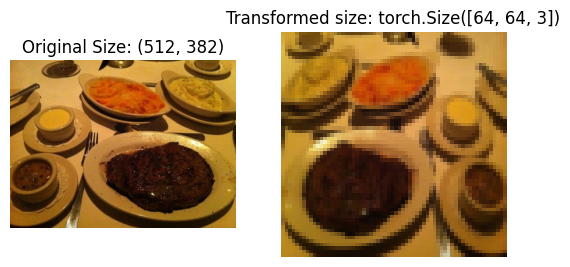

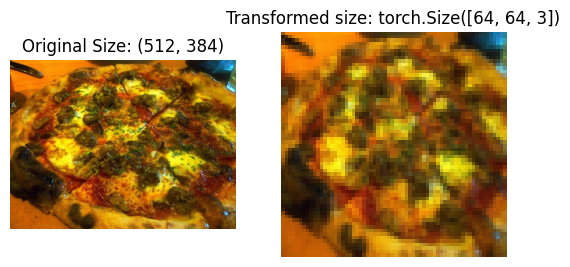

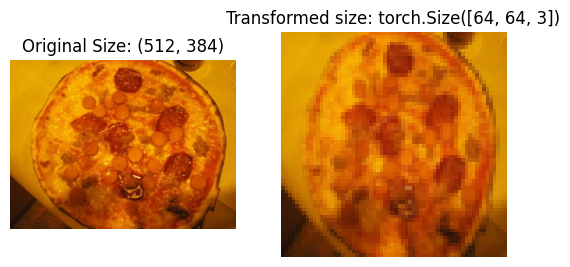

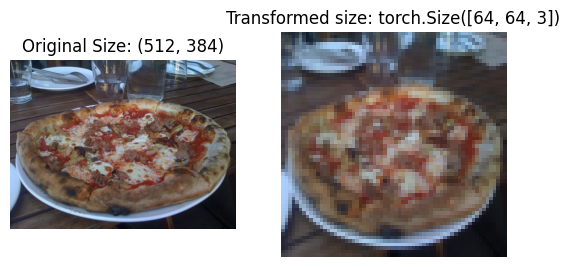

In [14]:
def plot_transformed_images(image_paths , transform , n , seed):
  random.seed(42)
  random_image = random.sample(image_path_list , k = n)
  for i in random_image:
    with Image.open(i) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformed_images(image_paths = image_path_list , transform =
                        data_transform , n = 4 ,
                        seed = 42)

#Using ImageFolders to create Datasets

In [15]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform = None,
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform,
    target_transform = None
)

In [16]:
test_dir

PosixPath('data/pizza-steak-sushi/test')

In [17]:
train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
#Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
#Get class names as dict
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
#Get the length of the data
print(f"Length of train_data : {len(train_data)}")
print(f"Length of test_data : {len(test_data)}")

Length of train_data : 225
Length of test_data : 75


In [21]:
#Index on the train_data Dataset to get a single image and label
img , label = train_data[0][0] , train_data[0][1]

In [22]:
img.shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'pizza')

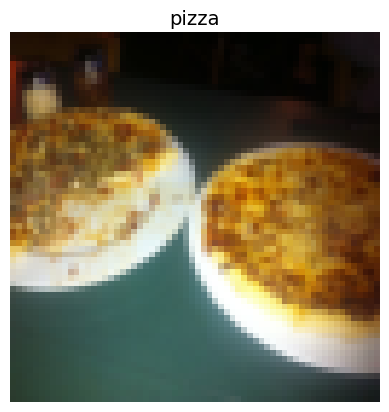

In [23]:
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label] , fontsize = 14)

#Turn loaded images into DataLoader's
A DataLoader is going to help us turn our Dataset 's into iterables and we can customise the batch_size so our model can see batch_size
images at a time.

In [24]:
import os
os.cpu_count()

2

In [25]:
#Turn train and test datasets into DataLoader's4
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data , batch_size = 32 ,
                              num_workers = os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data , batch_size = 32,
                             num_workers = os.cpu_count() ,
                             shuffle = True)

In [26]:
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c9e410fe3b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9e41122740>)

In [27]:
len(train_dataloader) , len(test_dataloader)

(8, 3)

In [28]:
img , label = next(iter(train_dataloader))

print(f"Image shape : {img.shape} -> [batch_size ,color_channels, height , width]")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([32, 3, 64, 64]) -> [batch_size ,color_channels, height , width]
Label shape : torch.Size([32])


 Option 2: Loading Image Data with a Custom `Dataset`


Want to be able to load images from file


Want to be able to get class names from the Dataset.


Want to be able to get classes as dictionary from the Dataset

In [29]:
target_directory = train_dir

In [30]:
def find_classes(directory):
  #Finds the class folder names in a target directory
  #Get the class names by scanning the target directory
  classes =  sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #Create a dictionary of index labels (computer prefer numbers rather than strings as labels)
  class_to_idx = {class_names : i for i,class_names in enumerate (classes)}
  return classes,class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#Create a custom Dataset to replace ImageFolder

To create our own custom dataset, we want to:
1. Subclass torch.utils.data.Dataset


2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.


3. Create several attributes:
paths - paths of our images transform - the transform we'd like to use
classes - a list of the target classes
class_to_idx - a dict of the target classes mapped to integer labels


4. Create a function to load_images ( ), this function will open an image


5. Overwrite the len ( ) _ method to return the length of our dataset


6. Overwrite the _ getitem ( ) _ method to return a given sample when passed an index

In [103]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,targ_dir,transform):
    self.paths = list(Path(targ_dir).glob("*/*"))

    self.transform = transform

    self.classes , self.class_to_idx = find_classes(targ_dir)

  #Create a function to load images
  def load_images(self,index):
    image_path = self.paths[index]
    return Image.open(image_path)

  #Return the length
  def __len__(self):
    return len(self.paths)

  #__getitem__() method to return a particular sample
  def __getitem__(self,index):
    #Return one sample of data , data and label
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img) , class_idx
    else:
      return img,class_idx


In [104]:
#Create a transform

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [105]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [106]:
train_data_custom , test_data_custom

(<__main__.ImageFolderCustom at 0x7c9e3013ffa0>,
 <__main__.ImageFolderCustom at 0x7c9e3013d720>)

In [107]:
len(train_data) , len(train_data_custom)

(225, 225)

In [108]:

len(test_data) , len(test_data_custom)

(75, 75)

In [109]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [110]:
test_data_custom.classes

['pizza', 'steak', 'sushi']

In [111]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [112]:
#Checking the equality between original Image Folder Dataset and ImageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


#Create function to display random images
1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [113]:
import matplotlib.pyplot as plt

In [114]:
#Create a function to take in a dataset
def display_random_images(dataset , classes , n , seed):

  #Setting up random seed
  random.seed(seed)

  #Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)),k=n)

  #Setting up matplotlib
  plt.figure(figsize=(16,8))

  #set up plot
  for i , targ_sample in enumerate(random_sample_idx):
    targ_image , targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1,2,0) # [height,width,color_channels]

    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class : {classes[targ_label]}"
      #if display_shape:
        #title = title + f"\nshape : {targ_image_adjust.shape}"
    plt.title(title)


In [115]:
random.sample(range(len(train_data)),k=10)

[60, 220, 164, 127, 99, 174, 41, 6, 105, 139]

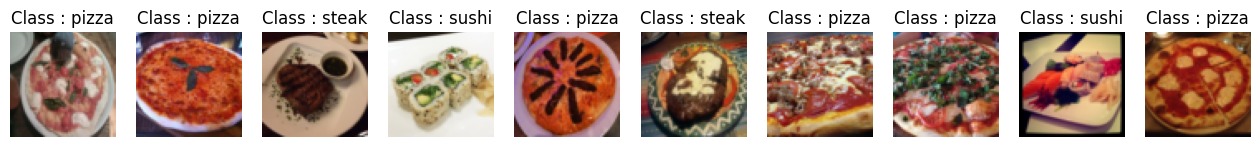

In [116]:
display_random_images(train_data , class_names , 10 , seed = None)

#Turn custom loaded images into DataLoader's



In [117]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset = train_data_custom , batch_size = BATCH_SIZE ,
                                     num_workers = os.cpu_count() , shuffle = True)
test_dataloader_custom = DataLoader(dataset = test_data_custom , batch_size = BATCH_SIZE ,
                                    num_workers = os.cpu_count() , shuffle  =True)

In [118]:
train_dataloader_custom , test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c9e3017d6c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c9e3017c6d0>)

In [119]:
#Get image and label from custom DataLoader
img_custom , label_custom = next(iter(train_dataloader_custom))

In [120]:
img_custom.shape , label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))